In [1]:
import apogee.tools.read as apread
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python2.7/site-packages/pkg_resources.py:1054: UserWarning: /home/price-jones/.python-eggs is writable by group/others and vulnerable to attack when used with get_resource_filename. Consider a more secure location (set with .set_extraction_path or the PYTHON_EGG_CACHE environment variable).
  warnings.warn(msg, UserWarning)


In [69]:
import apogee.spec

In [2]:
data = apread.rcsample()

In [3]:
def get_spectra_asp(data,ext = 1,header=False):
    """
    Returns spectra and header information for each object specified in data
    
    data:    labels for a subset of the APOGEE survey
    """
    specs = []
    hdrs = {}
    for i in range(len(data)):
        spec = apread.aspcapStar(data['LOCATION_ID'][i],data['APOGEE_ID'][i],ext = ext, header = header, aspcapWavegrid=True)
        if header:
            spec,hdr = spec
            hdrs[i] = hdr
        specs.append(spec)
    if header:
        return np.array(specs),hdrs
    elif not header:
        return np.array(specs)

def get_spectra_ap(data,ext = 1, header = False):
    specs = []
    hdrs = {}
    for i in range(len(data)):
        spec = apread.apStar(data['LOCATION_ID'][i],data['APOGEE_ID'][i],ext = ext, header = header, aspcapWavegrid=True)
        if header:
            spec,hdr = spec
            hdrs[i] = hdr
        specs.append(spec)
    if header:
        return np.array(specs),hdrs
    elif not header:
        return np.array(specs)

def makematrix_indep(x,order):
    if isinstance(x,tuple):
        nindeps = len(x)
        X = np.empty((len(x[0]),order*nindeps+1))
        X[:,0] = x[0]**0
        i = 1
        while i < order*nindeps+1:
            for o in range(1,order+1):
                for n in range(nindeps):
                    X[:,i] = x[n]**o
                    i+=1
    elif isinstance(x,(list,np.ndarray)):
        X = np.empty((len(x),order+1))
        for o in range(order+1):
            X[:,o] = x**o
    X = np.matrix(X)
    return X

def regfit(x,y,err = 0,order = 1):
    """
    Fits a (nD-)polynomial of specified order with independent values given in x,
    given dependent values in y.
    
    x:       array of independent variable 
            (may be tuple containing arrays of multiple variables)   
    y:       array of dependent variable (must have same shape as array in x)
    order:   order of polynomial to fit (kwarg, default = 1)
    
    Returns the polynomial coefficents ascending from 0th order. In the case of
    multiple independent variables, returns coefficients at each polynomial order
    in order of the variables listed in x.
    """
    X = makematrix_indep(x,order)
    if isinstance(err,(float,int)):
        return np.array(np.linalg.inv(X.T*X)*X.T*np.matrix(y).T)
    elif isinstance(err,(list,np.ndarray)):
        cov = np.diag(err**2)
        icov = np.linalg.inv(cov)
        return np.array(np.linalg.inv(X.T*icov*X)*(X.T*icov*np.matrix(y).T))

def regerr(x,y,xerr,yerr,order=1):
    X = makematrix(x,order)
    Xerr = makematrix(xerr,order)
    

def poly_indep(p,x,param = None,order = 1):
    """
    For a given set of polynomial coefficients ascending from
    0th order, and a independent variables, returns polynomial.
    """
    if isinstance(x,tuple):
        nindeps = len(x)
        order = (len(p)-1)/nindeps
        y = np.zeros(x[0].shape)
        y += p[0]*x[0]**0
        i = 1
        while i < order*nindeps+1:
            for o in range(1,order+1):
                if param == None:
                    for n in range(nindeps):
                        y+=p[i]*x[n]**o
                        i+=1
                elif param != None:
                    n = param
                    y+=p[i]*x[n]**o
                    i+=1
    elif isinstance(x,(list,np.ndarray)):
        order = len(p)-1
        y = np.zeros(x.shape)
        o = 0
        while o <= order:
            y += p[o]*x**o
            o += 1
    return y

def stderr(yreal,yfit,p):
    return np.sqrt(np.sum((yreal-yfit)**2)/(len(yreal)-len(p)))

In [19]:
# Basic function testing
x = np.arange(2,5,0.01)
c = np.log(np.copy(x))
y = np.copy(x)**3+c**2+9
ptest = regfit((x,c),y,order = 3)

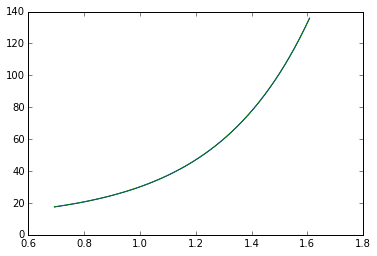

In [20]:
# Basic function testing
plt.plot(c,y)
plt.plot(c,poly(ptest,(x,c),order = 3))

In [4]:
def slice_data(data,sliceinfo):
    label, lower, upper = sliceinfo
    indx = (data[label]>lower) & (data[label]<upper)
    return data[indx]

def pixmask_find(maskdata,pix):
    mask = []
    for i in range(len(maskdata)):
        if len(maskdata[i].shape) > 1:
            if any(maskdata[i][:,pix]) != 0:
                mask.append(1)
            elif all(maskdata[i][:,pix]) == 0:
                mask.append(0)
        elif len(maskdata[i].shape) == 1:
            if maskdata[i][pix] != 0:
                mask.append(1)
            elif maskdata[i][pix] == 0:
                mask.append(0)   
    indx = np.where(np.array(mask) != 1)
    return indx

In [5]:
sdata = slice_data(data,['FE_H',-0.5,-0.4])
pix = 6296
maskdata = get_spectra_ap(sdata,ext = 3, header = False)
mask = pixmask_find(maskdata,pix)
mdata = sdata[mask]
mdata
specs,hdrs = get_spectra_asp(mdata,header = True)
errs = get_spectra_asp(mdata,ext = 2, header = False)
O = 2
p = regfit((mdata['TEFF'],mdata['LOGG'],mdata['METALS']),specs[:,pix],err = errs[:,pix],order = O)
p
#u = stderr(specs[:,pix],poly_indep(p,(Teff,logg,metals),p))

array([[ -1.11880921e-01],
       [  4.83481745e-04],
       [ -3.59468738e-01],
       [  1.22774727e+00],
       [ -3.50021032e-08],
       [  7.31115472e-02],
       [  1.25112650e+00]])

In [6]:
Teff = np.arange(min(mdata['TEFF']),max(mdata['TEFF']))
logg = np.arange(min(mdata['LOGG']),max(mdata['LOGG']),((max(mdata['LOGG']-min(mdata['LOGG'])))/len(Teff)))
metals = np.arange(min(mdata['METALS']),max(mdata['METALS']),((max(mdata['METALS']-min(mdata['METALS'])))/len(Teff)))
pl = np.where(errs[:,pix] < 0.1)
rpl = np.where(errs[:,pix] > 0.1)

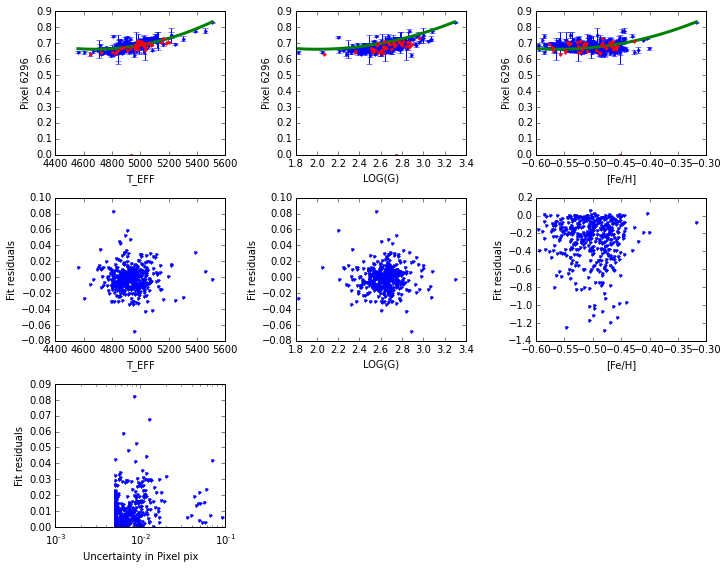

In [7]:
plt.figure(figsize = (10,8))
plt.subplot2grid((3,3),(0,0))
plt.errorbar(mdata['TEFF'][pl],specs[:,pix][pl],yerr = errs[:,pix][pl],fmt='.')
plt.plot(Teff,poly_indep(p,(Teff,logg,metals),order = O),linewidth = 3)
plt.plot(mdata['TEFF'][rpl],specs[:,pix][rpl],'.')
plt.xlabel('T_EFF')
plt.ylabel('Pixel {0}'.format(pix))
plt.subplot2grid((3,3),(1,0))
plt.plot(mdata['TEFF'][pl],specs[:,pix][pl] - poly_indep(p,(mdata['TEFF'][pl],mdata['LOGG'][pl],mdata['METALS'][pl]),order = O),'.')
plt.xlabel('T_EFF')
plt.ylabel('Fit residuals')
plt.subplot2grid((3,3),(2,0))
plt.semilogx(errs[:,pix][pl],abs(specs[:,pix][pl] - poly_indep(p,(mdata['TEFF'][pl],mdata['LOGG'][pl],mdata['METALS'][pl]))),'.')
plt.xlabel('Uncertainty in Pixel pix')
plt.ylabel('Fit residuals')
plt.subplot2grid((3,3),(0,1))
plt.errorbar(mdata['LOGG'][pl],specs[:,pix][pl],yerr = errs[:,pix][pl],fmt='.')
plt.plot(logg,poly_indep(p,(Teff,logg,metals),order = O),linewidth = 3)
plt.plot(mdata['LOGG'][rpl],specs[:,pix][rpl],'.')
plt.xlabel('LOG(G)')
plt.ylabel('Pixel {0}'.format(pix))
plt.subplot2grid((3,3),(1,1))
plt.plot(mdata['LOGG'][pl],specs[:,pix][pl] - poly_indep(p,(mdata['TEFF'][pl],mdata['LOGG'][pl],mdata['METALS'][pl]),order = O),'.')
plt.xlabel('LOG(G)')
plt.ylabel('Fit residuals')
plt.tight_layout()
plt.subplot2grid((3,3),(0,2))
plt.errorbar(mdata['METALS'][pl],specs[:,pix][pl],yerr = errs[:,pix][pl],fmt='.')
plt.plot(metals,poly_indep(p,(Teff,logg,metals),order = O),linewidth = 3)
plt.plot(mdata['METALS'][rpl],specs[:,pix][rpl],'.')
plt.xlabel('[Fe/H]')
plt.ylabel('Pixel {0}'.format(pix))
plt.subplot2grid((3,3),(1,2))
plt.plot(mdata['METALS'][pl],specs[:,pix][pl] - poly_indep(p,(mdata['TEFF'][pl],mdata['LOGG'][pl],data['METALS'][pl]),order = O),'.')
plt.xlabel('[Fe/H]')
plt.ylabel('Fit residuals')

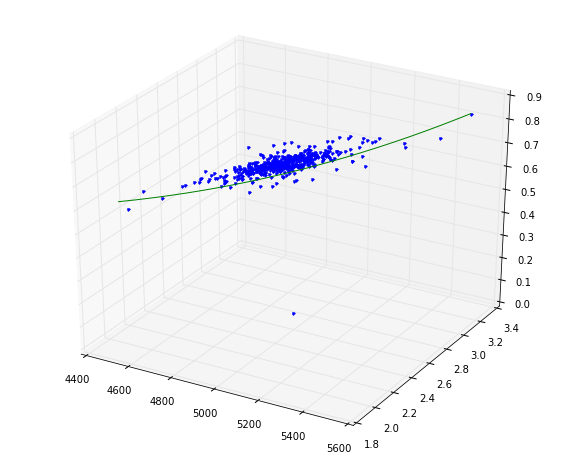

In [8]:
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(mdata['TEFF'],mdata['LOGG'],specs[:,6296],'.')
ax.plot(Teff,logg,poly_indep(p,(Teff,logg,metals)))

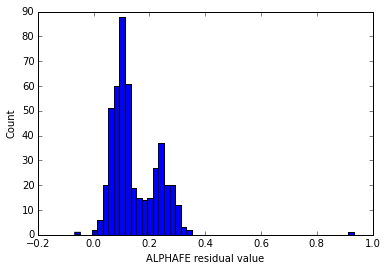

In [9]:
def histplot(res,mdata,abun_key,bins = 50,findgood = False):
    if findgood:
        good = np.where(mdata[abun_key] != -9999)
        newres = res[good]
        abun = mdata[abun_key][good]
    elif not findgood:
        newres = np.copy(res)
        abun = np.copy(mdata[abun_key])
    plt.hist(abun-newres,bins=bins)
    plt.xlabel('{0} residual value'.format(abun_key))
    plt.ylabel('Count')

bins = 50
res = specs[:,pix] - poly_indep(p,(mdata['TEFF'],mdata['LOGG'],mdata['METALS']),order = O)
histplot(res,mdata,'ALPHAFE')

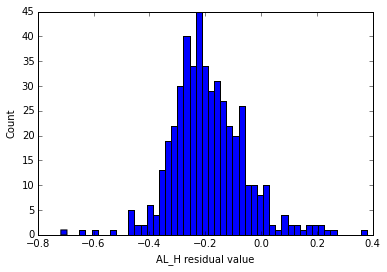

In [10]:
histplot(res,mdata,'AL_H',findgood=True)

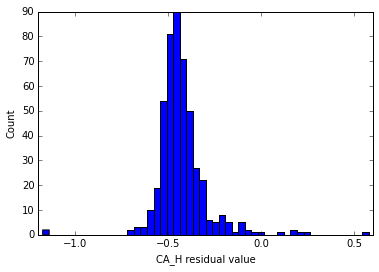

In [11]:
histplot(res,mdata,'CA_H',findgood=True)

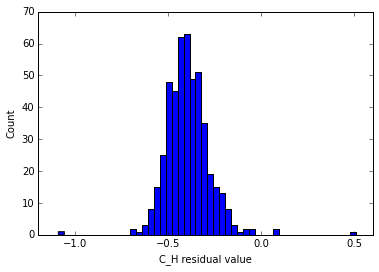

In [12]:
histplot(res,mdata,'C_H',findgood = True)

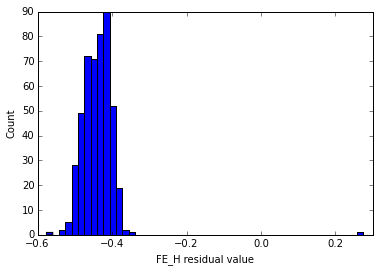

In [13]:
histplot(res,mdata,'FE_H',findgood=True)

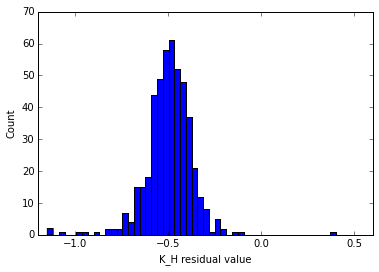

In [14]:
histplot(res,mdata,'K_H',findgood=True)

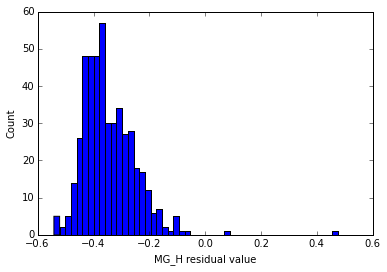

In [15]:
histplot(res,mdata,'MG_H',findgood=True)

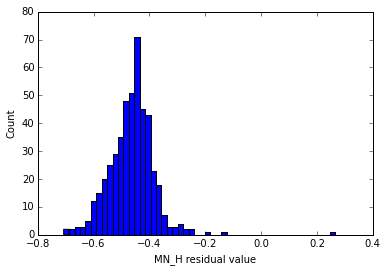

In [16]:
histplot(res,mdata,'MN_H',findgood=True)

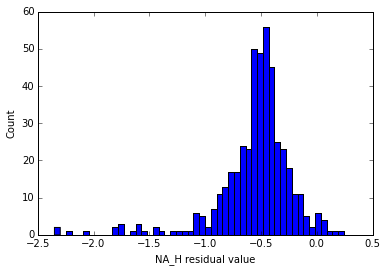

In [17]:
histplot(res,mdata,'NA_H',findgood=True)

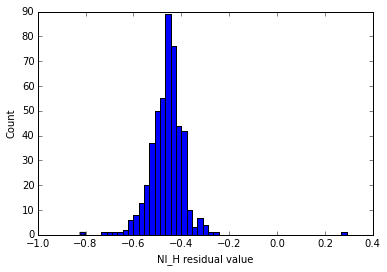

In [18]:
histplot(res,mdata,'NI_H',findgood=True)

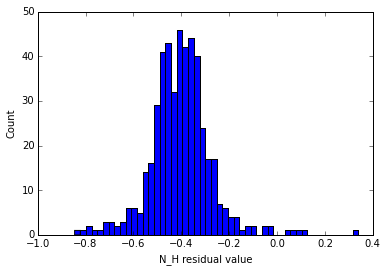

In [19]:
histplot(res,mdata,'N_H',findgood=True)

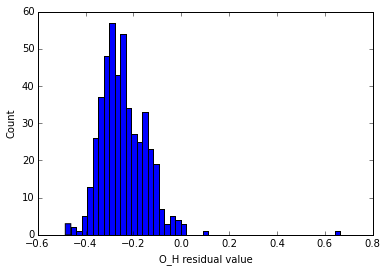

In [20]:
histplot(res,mdata,'O_H',findgood=True)

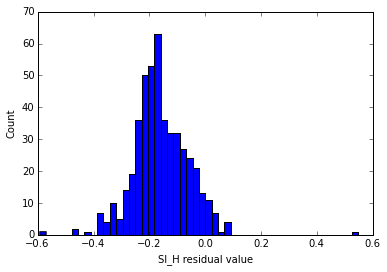

In [21]:
histplot(res,mdata,'SI_H',findgood=True)

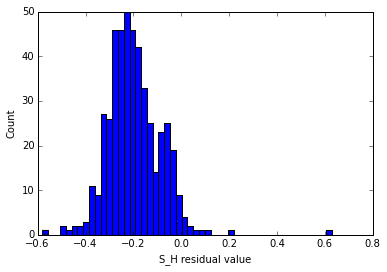

In [22]:
histplot(res,mdata,'S_H',findgood=True)

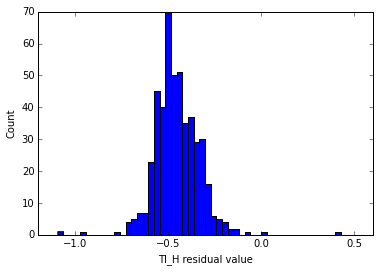

In [23]:
histplot(res,mdata,'TI_H',findgood=True)

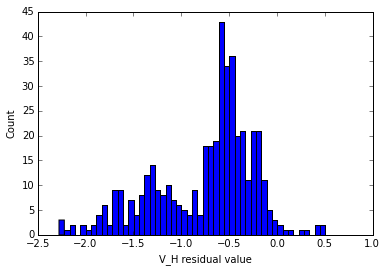

In [24]:
histplot(res,mdata,'V_H',findgood=True)

In [27]:
plt.ion()
def histplot2d(x,y,nbins = 50 ,maskval = 0,saveloc = '',labels=[]):
	"""
	Creates a 2D histogram from data given by numpy's histogram

	x,y:		two 2D arrays to correlate
	nbins:		number of bins
	maskval:	value that indicates masked areas
				(kwarg, default = 0)
	saveloc:	place to save histogram plot - if unspecified, do not
				save plot (kwarg, default = '')
	labels:		labels for histogram plot, with the following format
				[title,xlabel,ylabel,zlabel] - if unspecified, do 
				not label plot (kwarg, default = [])
	slope:		slope of correlation fit line (kwarg, default = 1)
	slopeerr:	uncertainties in slope of fit line (kwarg, default = 0)

	Returns the edges of the histogram bins and the 2D histogram

	"""
	# Remove NANs and masked values
	good = np.where((isnan(x) == False) & (isnan(y) == False) & (x != maskval) & (y != maskval))
	x = x[good]
	y = y[good]
	uplim = np.max(x)+5
	dolim = np.min(x)-5
	# Create histogram
	H,xedges,yedges = np.histogram2d(x,y,bins=nbins)
	# Reorient appropriately
	H = np.rot90(H)
	H = np.flipud(H)
	# Mask zero value bins
	Hmasked = ma.masked_where(H==0,H)
	# Begin creating figure
	plt.figure(figsize=(12,10))
	# Make histogram pixels with logscale
	plt.pcolormesh(xedges,yedges,Hmasked,
	               norm = LogNorm(vmin = Hmasked.min(),
	                              vmax = Hmasked.max()),
		       	   cmap = plt.get_cmap('Spectral_r'))
	# Set plot limits
	plt.xlim(dolim+5,uplim-5)
	plt.ylim(np.min(y),np.max(y))
	# Add colourbar
	cbar = plt.colorbar()
	# Add labels
	if labels != []:
	    title,xlabel,ylabel,zlabel = labels
	    plt.xlabel(xlabel)
	    plt.ylabel(ylabel)
	    plt.title(title)
	    cbar.ax.set_ylabel(zlabel)
	# Save plot
	if saveloc != '':
		plt.savefig(saveloc)
        plt.close()
	# Return histogram
	return xedges,yedges,Hmasked
#good = np.where(data['FE_H'] != -9999)
a = histplot2d(data['FE_H'],data['ALPHAFE'],nbins = 50 ,maskval = -9999,saveloc = '/home/price-jones/Code/APOGEE/rcapogee-plots/sequences.png',labels=['Sequences','[Fe/H]','[Alpha/Fe]','Number of RC stars'])